In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-prices-dataset/Housing.csv


In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# This option helps us to show all the columns. If not done, we dont clearly see the middle columns when using methods like describe().

pd.set_option('display.max_columns', None)

In [20]:
df = pd.read_csv('/kaggle/input/housing-prices-dataset/Housing.csv')

In [21]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [22]:
df.shape

(545, 13)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [24]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Our data is clean. So we will move forward to handling catagorical columns

Outlier datection

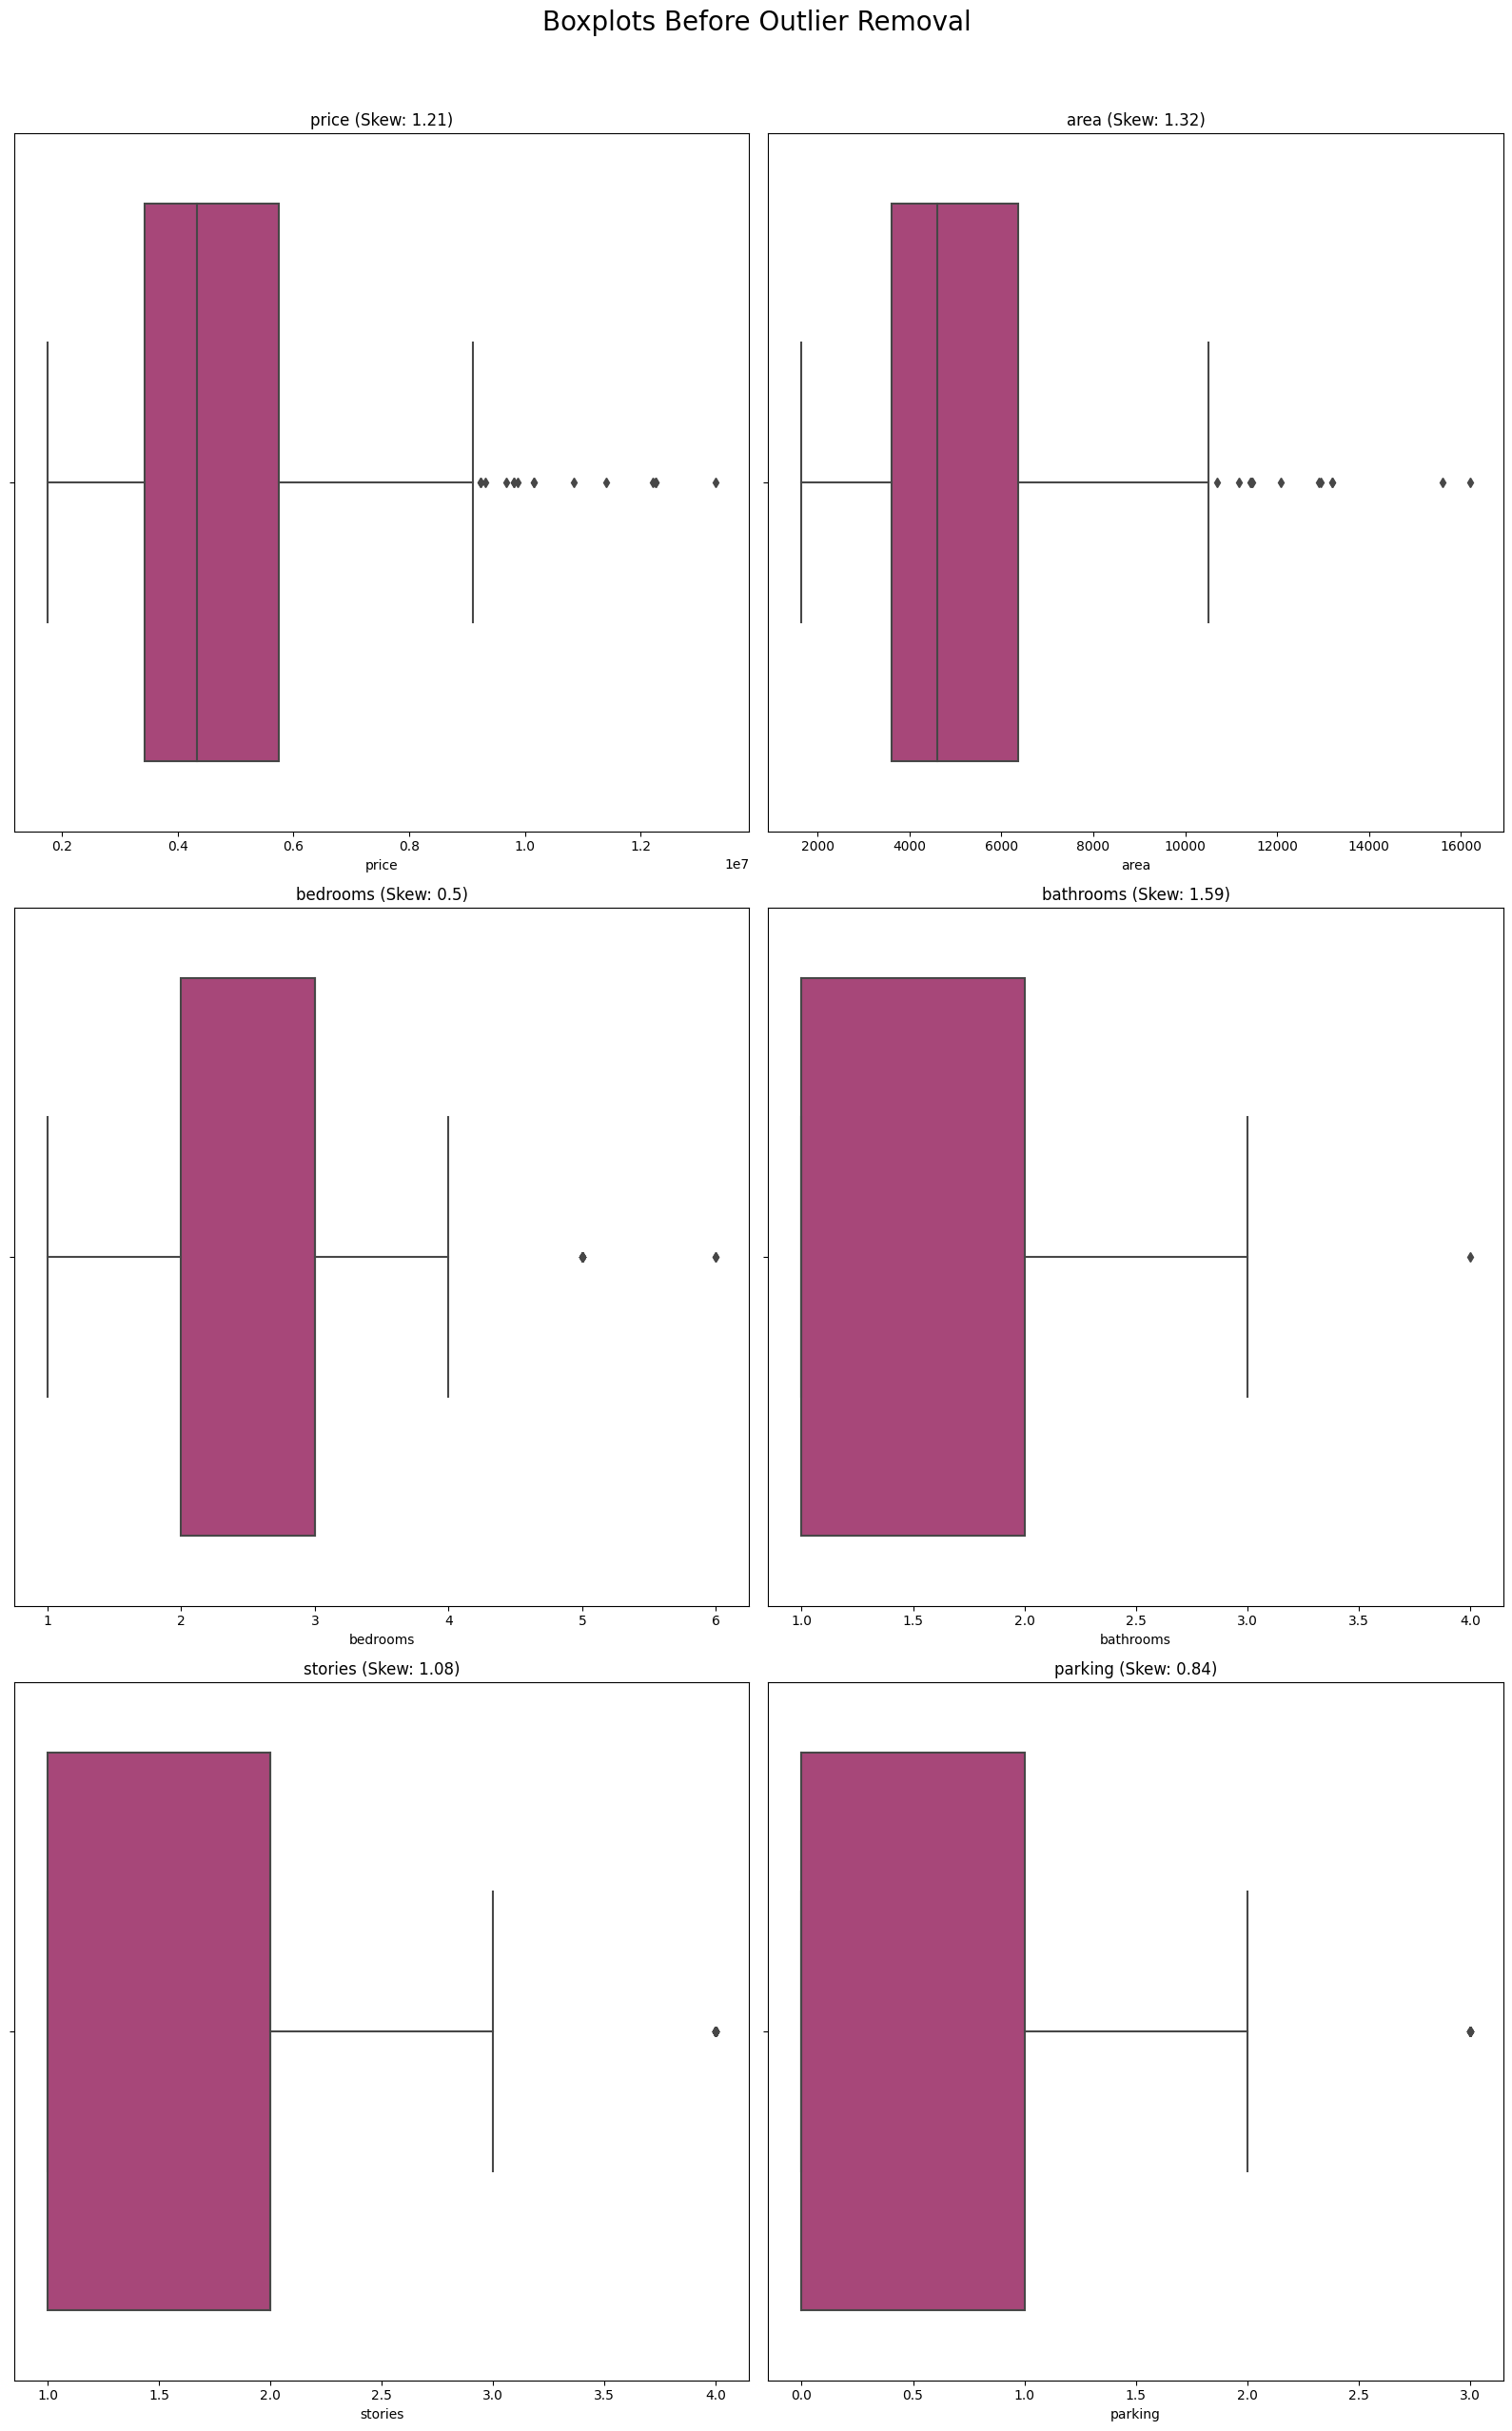

In [25]:
num_features = df.select_dtypes(include=[np.number]).columns.tolist()

def visualize_boxplots(data, features, row_count, col_count, main_title):
    fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(16, 25), sharey=True)
    fig.suptitle(main_title, fontsize=20, y=1.02)
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        sns.boxplot(x=data[feature], ax=axes[idx], palette="magma")
        skew_value = round(data[feature].skew(), 2)
        axes[idx].set_title(f"{feature} (Skew: {skew_value})", fontsize=12)

    plt.tight_layout()
    plt.show()

visualize_boxplots(df, num_features, row_count=3, col_count=2, main_title="Boxplots Before Outlier Removal")


1. Encoding for catagorical columns

In [26]:
# We will use default, o->no, 1->yes
binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
label_enc = LabelEncoder()
for feature in binary_features:
    df[feature] = label_enc.fit_transform(df[feature])

# Ordinal Encoding for furnishing status -> we want rankingss here...
ordinal_enc = OrdinalEncoder()
df[['furnishingstatus']] = ordinal_enc.fit_transform(df[['furnishingstatus']])

Train Test Split

In [27]:
X = df.drop(columns=['price'])
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Standard Scaler for Scaling Numerical Features

In [28]:
scaler = StandardScaler()
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols].copy())
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols].copy())

Model Training

In [30]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'ElasticNet Regression': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1)
}

In [31]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }

In [32]:
print(pd.DataFrame(results).T)

                                MAE           MSE          RMSE        R²
Linear Regression      9.796797e+05  1.771751e+12  1.331071e+06  0.649475
Ridge Regression       9.811993e+05  1.776276e+12  1.332770e+06  0.648580
ElasticNet Regression  1.107501e+06  2.268442e+12  1.506135e+06  0.551210
Random Forest          1.025802e+06  1.963038e+12  1.401085e+06  0.611631
XGBoost                1.062316e+06  2.032405e+12  1.425624e+06  0.597908


Hyperparameter Tuning

In [33]:
# Hyperparameter Tuning for all the models...
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_elasticnet = {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]}
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2]}


In [34]:
best_models = {}

# for ridge and Elasticnet

for name, model, params in [('Ridge Regression', Ridge(), param_grid_ridge),
                             ('ElasticNet Regression', ElasticNet(), param_grid_elasticnet)]:
    grid_search = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# for rf and XGB -> same code
for name, model, params in [('Random Forest', RandomForestRegressor(random_state=42, n_jobs=-1), param_grid_rf),
                             ('XGBoost', XGBRegressor(random_state=42, n_jobs=-1), param_grid_xgb)]:
    grid_search = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")


Best parameters for Ridge Regression: {'alpha': 10.0}
Best parameters for ElasticNet Regression: {'alpha': 0.1, 'l1_ratio': 0.8}
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [35]:
# best_results={}
for name, model in best_models.items():
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Store the results
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }

# Print the results for each model
for name, result in results.items():
    print(f"Results for {name}:")
    print(f"MAE: {result['MAE']}")
    print(f"MSE: {result['MSE']}")
    print(f"RMSE: {result['RMSE']}")
    print(f"R²: {result['R²']}\n")



Results for Linear Regression:
MAE: 979679.6912959907
MSE: 1771751116594.0398
RMSE: 1331071.4167895124
R²: 0.6494754192267794

Results for Ridge Regression:
MAE: 991858.3573965959
MSE: 1811248656215.0085
RMSE: 1345826.3841279857
R²: 0.6416611961186103

Results for ElasticNet Regression:
MAE: 990657.5331571739
MSE: 1806752066053.8025
RMSE: 1344154.7775661114
R²: 0.6425508049165974

Results for Random Forest:
MAE: 1025801.5169724772
MSE: 1963038128581.4658
RMSE: 1401084.6257744269
R²: 0.6116310521166004

Results for XGBoost:
MAE: 977687.8922018348
MSE: 1711779053916.9329
RMSE: 1308349.7444937774
R²: 0.6613403374599959



In [36]:
import joblib
joblib.dump(best_models['Ridge Regression'], 'best_house_price_model.pkl')
print("Best model (Ridge Regression) saved as 'best_house_price_model.pkl'.")


Best model (Ridge Regression) saved as 'best_house_price_model.pkl'.
